# Crop-yield prediction project
## Data Sources

This project performs a crop-yield prediction across Europe countries from 2000 to 2021. The dataset is collected from the following sources:

- Annual Yield (yield.csv) and Pesticides (pesticides.csv) are collected from Food and Agriculture Organization (FAO): https://www.fao.org/faostat/en/#data

- Annual Rainfall (rainfall.csv) and Avg. Temperature (avg_temp_1950-2014.csv and avg_temp_2015-2100.csv) are collected from World Data Bank: https://data.worldbank.org/

- The data is preprocessed and merged to achieve the final_data.csv file.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.offline as py
import seaborn as sns
py.init_notebook_mode(connected = True)# to see figure when plotting by px
sns.set_style('darkgrid')
plt.style.use('dark_background')

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model    import LinearRegression, BayesianRidge
from sklearn.tree            import DecisionTreeRegressor
from sklearn.ensemble        import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.neighbors       import KNeighborsRegressor
from xgboost                 import XGBRegressor
from lightgbm                import LGBMRegressor
from sklearn.metrics         import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

print("Packages OK")

Packages OK


# Exploratory Data Analysis (EDA)

In [5]:
# Read dataset and show some data points
data_dir = 'dataset//final_data.csv'
df = pd.read_csv(data_dir, encoding='latin1')
df.head()

,Number,Country,Item,Year,Yield (kg/ha),Pesticides (ton),Rainfall (mm/year),Avg. Temperature (°C)
0,0,Albania,Apples,2000,5217.4,307.98,1485,12.67
1,1,Albania,Apricots,2000,2015.6,307.98,1485,12.67
2,2,Albania,Cherries,2000,4566.2,307.98,1485,12.67
3,3,Albania,Grapes,2000,17190.5,307.98,1485,12.67
4,4,Albania,Maize (corn),2000,3881.1,307.98,1485,12.67


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4313 entries, 0 to 4312
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Number                 4313 non-null   int64  
 1   Country                4313 non-null   object 
 2   Item                   4313 non-null   object 
 3   Year                   4313 non-null   int64  
 4   Yield (kg/ha)          4313 non-null   float64
 5   Pesticides (ton)       4313 non-null   float64
 6   Rainfall (mm/year)     4313 non-null   int64  
 7   Avg. Temperature (°C)  4313 non-null   float64
dtypes: float64(3), int64(3), object(2)
memory usage: 269.7+ KB


In [7]:
df['Item'].value_counts()

Item
Potatoes        736
Wheat           714
Apples          714
Cherries        629
Maize (corn)    576
Grapes          514
Apricots        430
Name: count, dtype: int64

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Number,4313.0,2100.621377,1191.219202,0.00,1078.00,2156.00,3106.00,4184.00
Year,4313.0,2010.651287,6.289320,2000.00,2005.00,2011.00,2016.00,2021.00
Yield (kg/ha),4313.0,11634.401090,11141.895777,0.00,4381.20,7638.80,14440.10,91436.20
Pesticides (ton),4313.0,15053.734479,23531.825242,0.66,1218.15,3301.70,15344.40,99694.00
Rainfall (mm/year),4313.0,801.246000,341.326126,0.00,618.00,700.00,1028.00,1940.00
Avg. Temperature (°C),4313.0,9.648880,3.921004,-3.84,7.62,10.18,11.92,15.96


In [9]:
df.describe(include='object')

,Country,Item
count,4313,4313
unique,33,7
top,Luxembourg,Potatoes
freq,256,736


In [10]:
# Countries with the highest overall crop yield
df.groupby(['Country'], sort=True)[['Yield (kg/ha)']].sum().nlargest(10, 'Yield (kg/ha)')

,Yield (kg/ha)
Country,
Switzerland,3349625.1
Austria,3293968.7
Luxembourg,2966637.0
France,2696841.7
Slovenia,2559585.1
Belgium,2537045.2
Germany,2456914.6
Italy,2324784.7
Greece,1854414.6


In [11]:
# Highest yield of crops and their respective country
df.groupby(['Country', 'Item'], sort=True)['Yield (kg/ha)'].sum().nlargest(10)

Country      Item    
Luxembourg   Potatoes    1335823.8
Switzerland  Apples      1279473.7
Austria      Apples      1259867.9
Belgium      Potatoes     969808.9
France       Potatoes     931142.5
Germany      Potatoes     924562.9
Denmark      Potatoes     890178.3
Italy        Apples       872949.5
Switzerland  Potatoes     862467.3
Belgium      Apples       854740.8
Name: Yield (kg/ha), dtype: float64

array([[<Axes: title={'center': 'Number'}>,
        <Axes: title={'center': 'Year'}>],
       [<Axes: title={'center': 'Yield (kg/ha)'}>,
        <Axes: title={'center': 'Pesticides (ton)'}>],
       [<Axes: title={'center': 'Rainfall (mm/year)'}>,
        <Axes: title={'center': 'Avg. Temperature (°C)'}>]], dtype=object)

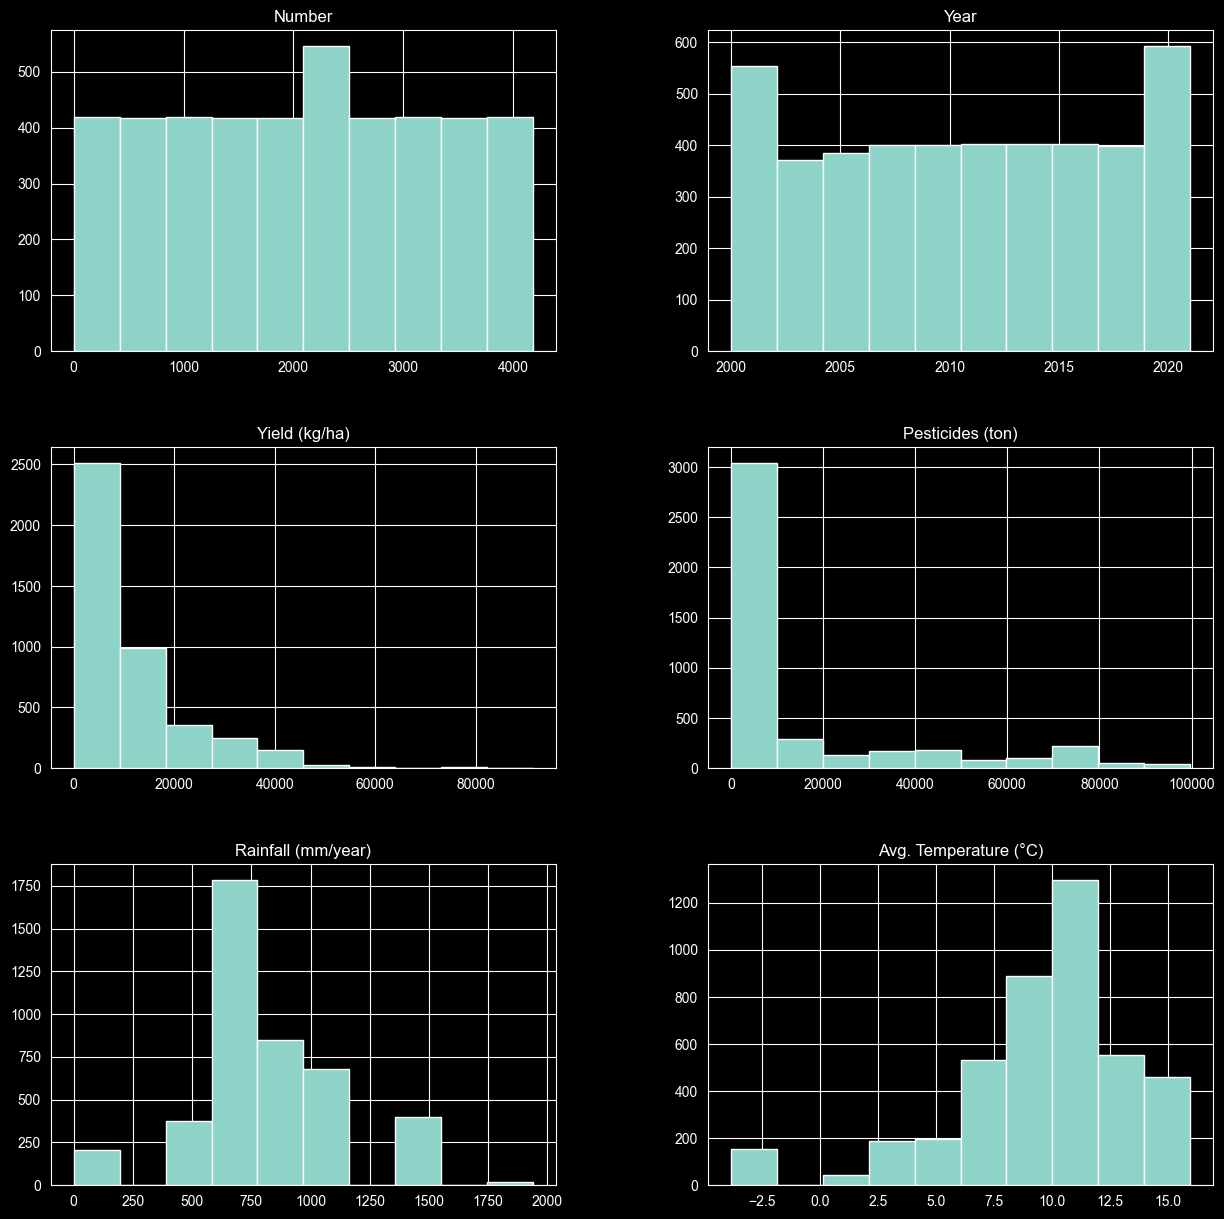

In [12]:
df.hist(figsize=(15, 15))

### Discussion:
- Most observed yields fall under 20 t/ha.
- Most pesticide usage is between 0-20kt.
- Most rainfall falls between 500 and 1000 mm annually.
- Popular average temperature is around 11°C (a cool-temperature regime).

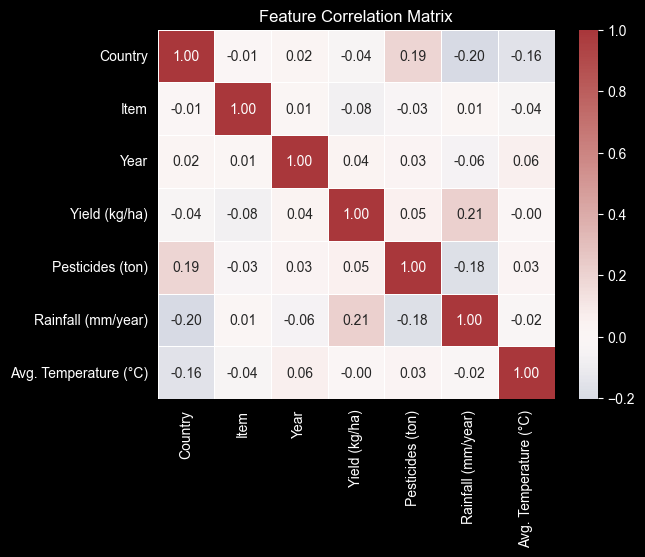

In [18]:
# Correlation matrix
from sklearn.preprocessing import LabelEncoder
df1 = df.copy()
df1.drop('Number', axis=1, inplace=True)

df1_list = df1.select_dtypes(include=['object']).columns.tolist()
label_encoder = LabelEncoder()

for col in df1_list:
    df1[col] = label_encoder.fit_transform(df1[col])
    
cm = sns.heatmap(
    df1.corr(),
    annot=True,        # write the correlation number in each cell
    fmt=".2f",         # number format
    cmap="vlag",       # diverging red–blue colormap
    center=0,          # zero in the middle of the colormap
    linewidths=.5      # lines between cells
)
plt.title("Feature Correlation Matrix")
plt.show()

# Data Processing

In [19]:
# Split into X, y
y = df['Yield (kg/ha)']
X = df.drop(columns=['Number', 'Yield (kg/ha)'])

#Convert X into dummy variables
X = pd.get_dummies(X)#one-hot encoding, turn each unique category into its own numeric feature (e.g., 'Country', 'Item'),
                     #since many ML models can't work directly with string or object-dtype columns.

# Train/test split
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1
)

print(y.head())
X.head()

0     5217.4
1     2015.6
2     4566.2
3    17190.5
4     3881.1
Name: Yield (kg/ha), dtype: float64


,Year,Pesticides (ton),Rainfall (mm/year),Avg. Temperature (°C),Country_Albania,Country_Austria,Country_Belarus,Country_Belgium,Country_Bosnia and Herzegovina,Country_Bulgaria,...,Country_Sweden,Country_Switzerland,Country_Ukraine,Item_Apples,Item_Apricots,Item_Cherries,Item_Grapes,Item_Maize (corn),Item_Potatoes,Item_Wheat
0,2000,307.98,1485,12.67,True,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
1,2000,307.98,1485,12.67,True,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
2,2000,307.98,1485,12.67,True,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
3,2000,307.98,1485,12.67,True,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
4,2000,307.98,1485,12.67,True,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False


# Machine Learning Models

In [20]:
# Define models
models = [
    ("Linear Regression",    LinearRegression()),
    ("Decision Tree",        DecisionTreeRegressor(random_state=1)),
    ("Random Forest",        RandomForestRegressor(random_state=1)),
    ("Gradient Boosting",    GradientBoostingRegressor(random_state=1)),
    ("XGBoost",              XGBRegressor(random_state=1)),
    ("LightGBM",             LGBMRegressor(random_state=1, verbosity=-1)),
    ("KNN",                  KNeighborsRegressor(n_neighbors=10)),
    ("Bayesian Ridge",       BayesianRidge()),
]

# Training and Evaluation

In [22]:
results = []
for name, model in models:
    print(f"\n>>> Training & evaluating: {name}")
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    
    mse = mean_squared_error(y_test, y_pred)
    r2  = r2_score(y_test, y_pred)
    print(f"  MSE = {mse:.2f},  R² = {r2:.3f}")
    results.append((name, mse, r2))
    
    # Build a tiny DataFrame for plotting
    plot_df = pd.DataFrame({
        "Actual":    y_test,
        "Predicted": y_pred
    })

    # Scatter + OLS trendline
    fig = px.scatter(
        plot_df,
        x="Actual",
        y="Predicted",
        title=f"{name} — Actual vs Predicted",
        labels={"Actual":"Actual Yield","Predicted":"Predicted Yield"},
        trendline="ols",
        trendline_color_override='red',
        template="plotly_dark",
        color_discrete_sequence=["green"]
    )
    fig.update_layout(width=600, height=450)
    fig.show()


>>> Training & evaluating: Linear Regression
  MSE = 57125359.80,  R² = 0.575



>>> Training & evaluating: Decision Tree
  MSE = 18366510.92,  R² = 0.863



>>> Training & evaluating: Random Forest
  MSE = 9967873.63,  R² = 0.926



>>> Training & evaluating: Gradient Boosting
  MSE = 28028813.41,  R² = 0.792



>>> Training & evaluating: XGBoost
  MSE = 11585863.04,  R² = 0.914



>>> Training & evaluating: LightGBM
  MSE = 11357904.50,  R² = 0.916



>>> Training & evaluating: KNN
  MSE = 126102874.05,  R² = 0.063



>>> Training & evaluating: Bayesian Ridge
  MSE = 126731079.64,  R² = 0.058


# Comparing Models

In [23]:
summary = pd.DataFrame(results, columns = ['Model', 'MSE', 'R2'])
summary_format =  (
    summary.style
    .highlight_max(subset = ['R2'], color='lightblue')
    .highlight_min(subset=['MSE'], color='lightblue')
    .highlight_max(subset=['MSE'], color='lightcoral')
    .highlight_min(subset=['R2'], color='lightcoral')
)
display(summary_format)

,Model,MSE,R2
0,Linear Regression,57125359.796805,0.575358
1,Decision Tree,18366510.921217,0.863472
2,Random Forest,9967873.627366,0.925904
3,Gradient Boosting,28028813.414715,0.791647
4,XGBoost,11585863.044332,0.913876
5,LightGBM,11357904.503723,0.915571
6,KNN,126102874.052048,0.062613
7,Bayesian Ridge,126731079.641793,0.057943


The preliminary benchmarking shows a clear hierarchy in predictive performance:

Random Forest leads the pack with the lowest MSE (~ 9.97 million) and highest R² (0.926), indicating it explains over 92 % of the variance in yield.

LightGBM (MSE ≈ 11.36 million, R² ≈ 0.916) and XGBoost (MSE ≈ 11.59 million, R² ≈ 0.914) follow closely, both offering very strong fits compared to the other methods.

The ensemble tree methods notably outperform both the single Decision Tree (R² ≈ 0.863) and the linear–based models (Linear Regression R² ≈ 0.575; Bayesian Ridge R² ≈ 0.058), highlighting the value of combining multiple trees to capture non-linear relationships in your crop‐yield data.

KNN, with R² barely above zero, clearly struggles here, likely because it can’t generalize well across high-dimensional, structured environmental features.

In the following, a deeper performance comparison is provided.

# K-Fold Cross Validation

## Introduction

- K-Fold Cross Validation is a resampling technique used to assess how a model will generalize to unseen data.

- Pipeline:

    - Split your dataset into k equally (or nearly equally) sized folds.

    - Perform k training rounds:

        - In each round, hold out one distinct fold as the validation set and train on the other k − 1 folds.

        - Evaluate the model's performance on that held-out fold.

        - After k rounds, aggregate the k validation scores (e.g. take the mean and standard deviation of MSE or R²) to estimate generalization performance.

- Advantages:

    - More reliable estimate
    
    - Efficient use of data
    
    - Variance assessment
    
    - Fair model comparison

In [31]:
from sklearn.model_selection import cross_validate, KFold

results = []
cv = KFold(n_splits = 5, shuffle=True, random_state=1)#optional: use n_jobs=-1 to process 5 folds parallelly

# Define scoring dict: note MSE is negated by sklearn
scoring = {
    'MSE': 'neg_mean_squared_error', #RandomizedSearchCV is used to find the best hyperparameters for each model.
    'R2': 'r2'
}

for name, model in models :
    print(f"Running CV for {name}...")
    scores = cross_validate(model, X, y, cv = cv, scoring=scoring)
    
    # Extract test scores
    mse_scores = -scores['test_MSE'] # flip sign back to positive MSE
    r2_scores  = scores['test_R2']    
    
    results.append({
        'Model': name,
        'MSE Mean': mse_scores.mean(),
        'MSE Std': mse_scores.std(),
        'R2 Mean': r2_scores.mean(),
        'R2 Std': r2_scores.std()
    })
    
    print(f"Mean MSE: {mse_scores.mean()}, Mean R2: {r2_scores.mean()}")
    print('-' * 30)

Running CV for Linear Regression...
Mean MSE: 48116067.9660639, Mean R2: 0.6115169573195376
------------------------------
Running CV for Decision Tree...
Mean MSE: 14897555.819133913, Mean R2: 0.8795157297206734
------------------------------
Running CV for Random Forest...
Mean MSE: 8820476.3513569, Mean R2: 0.9285580397587563
------------------------------
Running CV for Gradient Boosting...
Mean MSE: 22208137.71363824, Mean R2: 0.8207646243966028
------------------------------
Running CV for XGBoost...
Mean MSE: 9022667.166896002, Mean R2: 0.9273034773528022
------------------------------
Running CV for LightGBM...
Mean MSE: 9874406.288595319, Mean R2: 0.9201278831360288
------------------------------
Running CV for KNN...
Mean MSE: 115216299.96289206, Mean R2: 0.06319298847643377
------------------------------
Running CV for Bayesian Ridge...
Mean MSE: 101249798.97932853, Mean R2: 0.16070810188588955
------------------------------


In [34]:
print(scores)

{'fit_time': array([0.01400352, 0.01500106, 0.0150001 , 0.0114212 , 0.01185036]), 'score_time': array([0.0019989 , 0.00199962, 0.00199962, 0.00298429, 0.00355077]), 'test_MSE': array([-1.26731080e+08, -9.78610947e+07, -5.75319157e+07, -1.03926730e+08,
       -1.20198175e+08]), 'test_R2': array([0.05794277, 0.02484386, 0.60804553, 0.05647785, 0.0562305 ])}


In [32]:
# Build a DataFrame
cv_df = pd.DataFrame(results).set_index('Model')

# Display
print("\n=== 5-Fold CV Results ===")
# print(cv_df.to_string(float_format="%.2f"))
results_format = (
    cv_df.style
    .highlight_max(subset=['R2 Mean'], color='lightblue')
    .highlight_min(subset=['MSE Mean'], color='lightblue')
    .highlight_max(subset=['MSE Mean'], color='lightcoral')
    .highlight_min(subset=['R2 Mean'], color='lightcoral')
)
display(results_format)


=== 5-Fold CV Results ===


,MSE Mean,MSE Std,R2 Mean,R2 Std
Model,,,,
Linear Regression,48116067.966064,7540887.358266,0.611517,0.027212
Decision Tree,14897555.819134,2893014.148812,0.879516,0.016844
Random Forest,8820476.351357,1435219.635610,0.928558,0.008668
Gradient Boosting,22208137.713638,4020981.005552,0.820765,0.019351
XGBoost,9022667.166896,1852815.662950,0.927303,0.009889
LightGBM,9874406.288595,1418917.057115,0.920128,0.006215
KNN,115216299.962892,10081030.128427,0.063193,0.050219
Bayesian Ridge,101249798.979329,24241448.813118,0.160708,0.224013
